In [1]:
import os

import torch
import torchvision
import numpy as np

from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt


In [3]:
train_path = 'Database of 36 handwritten Kyrgyz letters - Train and Test/train'
test_path = 'Database of 36 handwritten Kyrgyz letters - Train and Test/test'

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

train_data = torchvision.datasets.ImageFolder(root=train_path,transform=trans)
test_data = torchvision.datasets.ImageFolder(root=test_path,transform=trans)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [5]:
class Kyrgyz(nn.Module):
    def __init__(self):
        super(Kyrgyz, self).__init__()
        self.features = nn.Sequential(
            # conv1 : 3 * 134 * 134
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            # conv2 : 16 * 66 * 66
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            # conv3 : 32 * 32 * 32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        # Flatten : 64 * 15 * 15
        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(
            nn.Linear(in_features=64*15*15, out_features=2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=2048, out_features=512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=512, out_features=36)
        )
    
    def forward(self,x):
        x = self.features(x)
        x = self.flatten(x)
        logits = self.classifier(x)
        return logits

In [6]:
model = Kyrgyz().to(device)
print(model)

Kyrgyz(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=14400, out_features=2048, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=2048, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=36, bias=True)
  )
)


In [7]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0.0
    top1_acc = 0.0
    top5_acc = 0.0
    size = len(dataloader.dataset)

    for batch_idx, (imgs,labels) in enumerate(dataloader):
        imgs, labels = imgs.to(device), labels.to(device)

        pred = model(imgs)
        loss = loss_fn(pred, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Top-1 accuracy
        predicted_1 = pred.argmax(1)
        top1_acc += (predicted_1 == labels).float().sum().item()

        # Top-5 accuracy
        _,predicted_5 = pred.topk(k=5, dim=1)
        labels_resize = labels.view(-1,1)
        top5_acc += torch.eq(predicted_5, labels_resize).float().sum().item()
        
        if batch_idx % 100 == 0:
            current = batch_idx * len(imgs)
            print(f"[{current:>5d}/{size:>5d}]")
    return total_loss/size, top1_acc/size, top5_acc/size

def test(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    total_loss = 0.0
    top1_acc = 0.0
    top5_acc = 0.0

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)

            pred = model(imgs)
            loss = loss_fn(pred, labels)

            total_loss += loss.item()

            # Top-1 accuracy
            predicted_1 = pred.argmax(1)
            top1_acc += (predicted_1 == labels).float().sum().item()

            # Top-5 accuracy
            _,predicted_5 = pred.topk(k=5, dim=1)
            labels_resize = labels.view(-1,1)
            top5_acc += torch.eq(predicted_5, labels_resize).float().sum().item()

    return total_loss/size, top1_acc/size, top5_acc/size


In [8]:
batch_size = 64
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [9]:
res = {
    "train_loss": [],
    "train_top1_acc": [],
    "train_top5_acc": [],
    "val_loss": [],
    "val_top1_acc": [],
    "val_top5_acc": [],
}

epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_top1, train_top5 = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_top1, val_top5 = test(test_dataloader, model, loss_fn)


    res['train_loss'].append(train_loss)
    res['train_top1_acc'].append(train_top1)
    res['train_top5_acc'].append(train_top5)

    res['val_loss'].append(val_loss)
    res['val_top1_acc'].append(val_top1)
    res['val_top5_acc'].append(val_top5)
    
print('Done!')

Epoch 1
-------------------------------
[    0/62301]
[ 6400/62301]
[12800/62301]
[19200/62301]
[25600/62301]
[32000/62301]
[38400/62301]
[44800/62301]
[51200/62301]
[57600/62301]
Epoch 2
-------------------------------
[    0/62301]
[ 6400/62301]
[12800/62301]
[19200/62301]
[25600/62301]
[32000/62301]
[38400/62301]
[44800/62301]
[51200/62301]
[57600/62301]
Epoch 3
-------------------------------
[    0/62301]
[ 6400/62301]
[12800/62301]
[19200/62301]
[25600/62301]
[32000/62301]
[38400/62301]
[44800/62301]
[51200/62301]
[57600/62301]
Epoch 4
-------------------------------
[    0/62301]
[ 6400/62301]
[12800/62301]
[19200/62301]
[25600/62301]
[32000/62301]
[38400/62301]
[44800/62301]
[51200/62301]
[57600/62301]
Epoch 5
-------------------------------
[    0/62301]
[ 6400/62301]
[12800/62301]
[19200/62301]
[25600/62301]
[32000/62301]
[38400/62301]
[44800/62301]
[51200/62301]
[57600/62301]
Epoch 6
-------------------------------
[    0/62301]
[ 6400/62301]
[12800/62301]
[19200/62301]
[256

KeyboardInterrupt: 

Text(0, 0.5, 'Top-5 Accuracy')

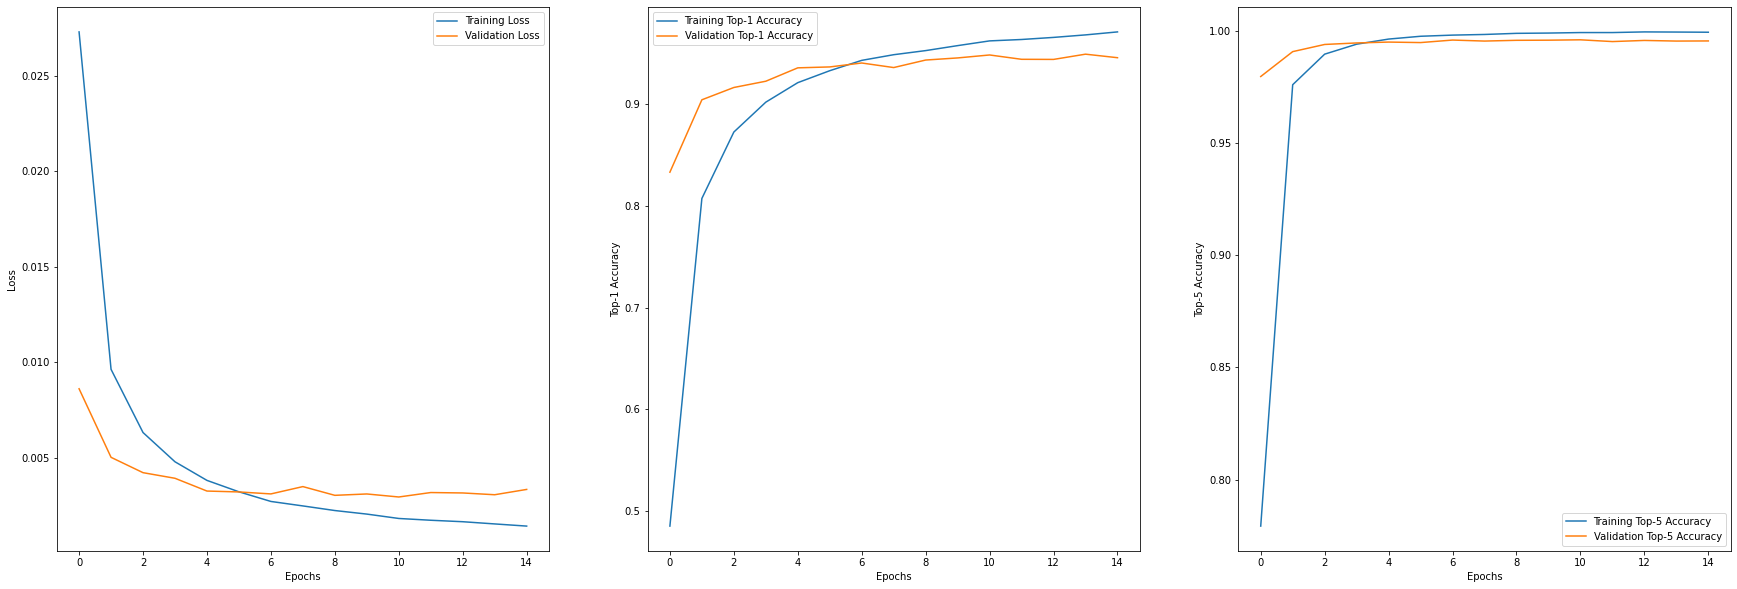

In [9]:
fig,ax = plt.subplots(1,3,figsize=(30,10))
x = np.arange(epochs)

ax[0].plot(x, res['train_loss'], label='Training Loss')
ax[0].plot(x, res['val_loss'], label='Validation Loss')
ax[0].legend(loc=0)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(x, res['train_top1_acc'], label='Training Top-1 Accuracy')
ax[1].plot(x, res['val_top1_acc'], label='Validation Top-1 Accuracy')
ax[1].legend(loc=0)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Top-1 Accuracy')

ax[2].plot(x, res['train_top5_acc'], label='Training Top-5 Accuracy')
ax[2].plot(x, res['val_top5_acc'], label='Validation Top-5 Accuracy')
ax[2].legend(loc=0)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Top-5 Accuracy')

In [10]:
print('Training Top-1 Accuracy: ',res['train_top1_acc'][epochs-1])
print('Validation Top-1 Accuracy: ',res['val_top1_acc'][epochs-1])
print('Trainging Top-5 Accuracy: ',res['train_top5_acc'][epochs-1])
print('Validation Top-5 Accuracy: ',res['train_top5_acc'][epochs-1])

Training Top-1 Accuracy:  0.9713487744980016
Validation Top-1 Accuracy:  0.9459580670478753
Trainging Top-5 Accuracy:  0.9994542623713905
Validation Top-5 Accuracy:  0.9994542623713905
